### Tech Challenge | Pós Data Analytics Fase 4 | Leonardo Dionello - RM358380

#### Análise Exploratória dos Dados (AED)

In [2]:
# Instalando as biliotecas Necessárias:
from datetime import datetime

# Bibliotecas padrões
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Bibliotecas específicas para o Machine Learning
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA

# Biblioteca dos teste
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

# Configurando aparência do fundo dos gráficos
sns.set_style('darkgrid')


z:\Pasta_Compartilhada\00_Pos-Graduação\Fase 4\tech_challenge_f4\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# -----------------------------------------------------------------------------------
# ------------------ BLOCO PARA AQUISIÇÃO DOS DADOS ---------------------------------
# -----------------------------------------------------------------------------------

# Acessando a base de dados da Ibovespa
dados_ipea = pd.read_csv(r'BD_DADOS_IPEA.csv', sep=';')

# Visualizando as primeiras linhas
dados_ipea.head(5)

,PERIODO,PRECO_FOB
0,02/05/2025,61.57
1,17/03/2025,71.93
2,24/12/2024,73.50
3,05/12/2024,73.78
4,22/12/2023,80.23


In [4]:
# Verificando se temos valores ausentes:
print("Valores ausentes no dataset:")
print(dados_ipea.isnull().sum())

Valores ausentes no dataset:
PERIODO      0
PRECO_FOB    0
dtype: int64


Para continuarmos, se faz necessária algumas alterações no dataframe, tais como:

    * Mudar o formato do campo DATA
    * Atribuir a DATA como Índice dos dados
    * Configurando a frequência para diária
    * Alterar o nome das colunas

In [5]:
# Renomeando as colunas principais
dados_ipea.rename(columns={'PRECO_FOB': 'y', 'PERIODO': 'ds'}, inplace=True)

# Ajustando o formato da data e atribuindo ela ao índice
dados_ipea.index = pd.to_datetime(dados_ipea.ds, format="%d/%m/%Y")

# Listando colunas para remover
colunas_para_remover = ['ds']

# Remover colunas
dados_ipea = dados_ipea.drop(columns=colunas_para_remover)

# Visualizando as mudanças
dados_ipea.head(5)

,y
ds,
2025-05-02,61.57
2025-03-17,71.93
2024-12-24,73.50
2024-12-05,73.78
2023-12-22,80.23


In [6]:
dados_ipea.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11415 entries, 2025-05-02 to 1987-05-20
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       11415 non-null  float64
dtypes: float64(1)
memory usage: 178.4 KB


##### Gerando a primeira Visualização da série histórica

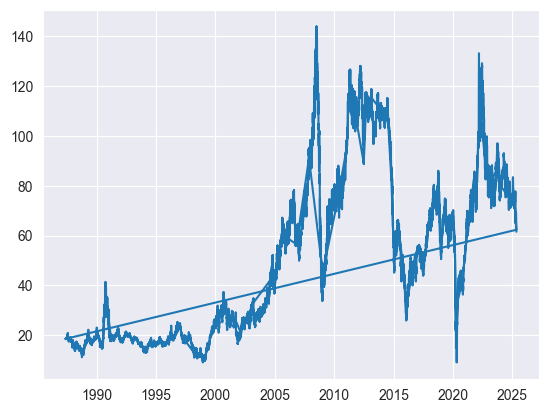

In [7]:
plt.plot(dados_ipea.index, dados_ipea.y)

Analisando os dados anuais, com o Boxplot

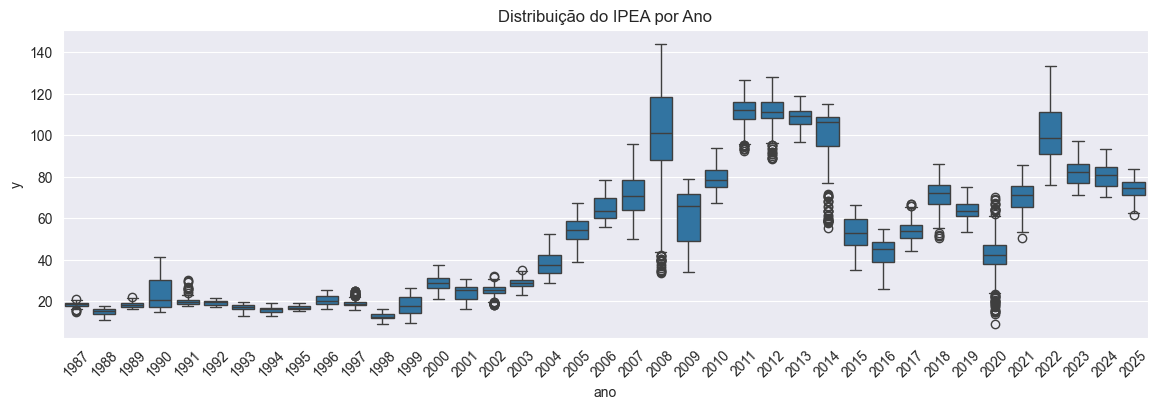

In [8]:
# Boxplot por ano
dados_ipea['ano'] = dados_ipea.index.year
plt.figure(figsize=(14, 4))
sns.boxplot(x='ano', y='y', data=dados_ipea)
plt.title('Distribuição do IPEA por Ano')
plt.xticks(rotation=45)
plt.show()

Os dados possuem apenas dias da Semana, para trabalharmos com a série temporal, criaremos um outro dataframe diário e os valores vazios utilizaremos o valor anterior:

#### Aplicando o método decomposing


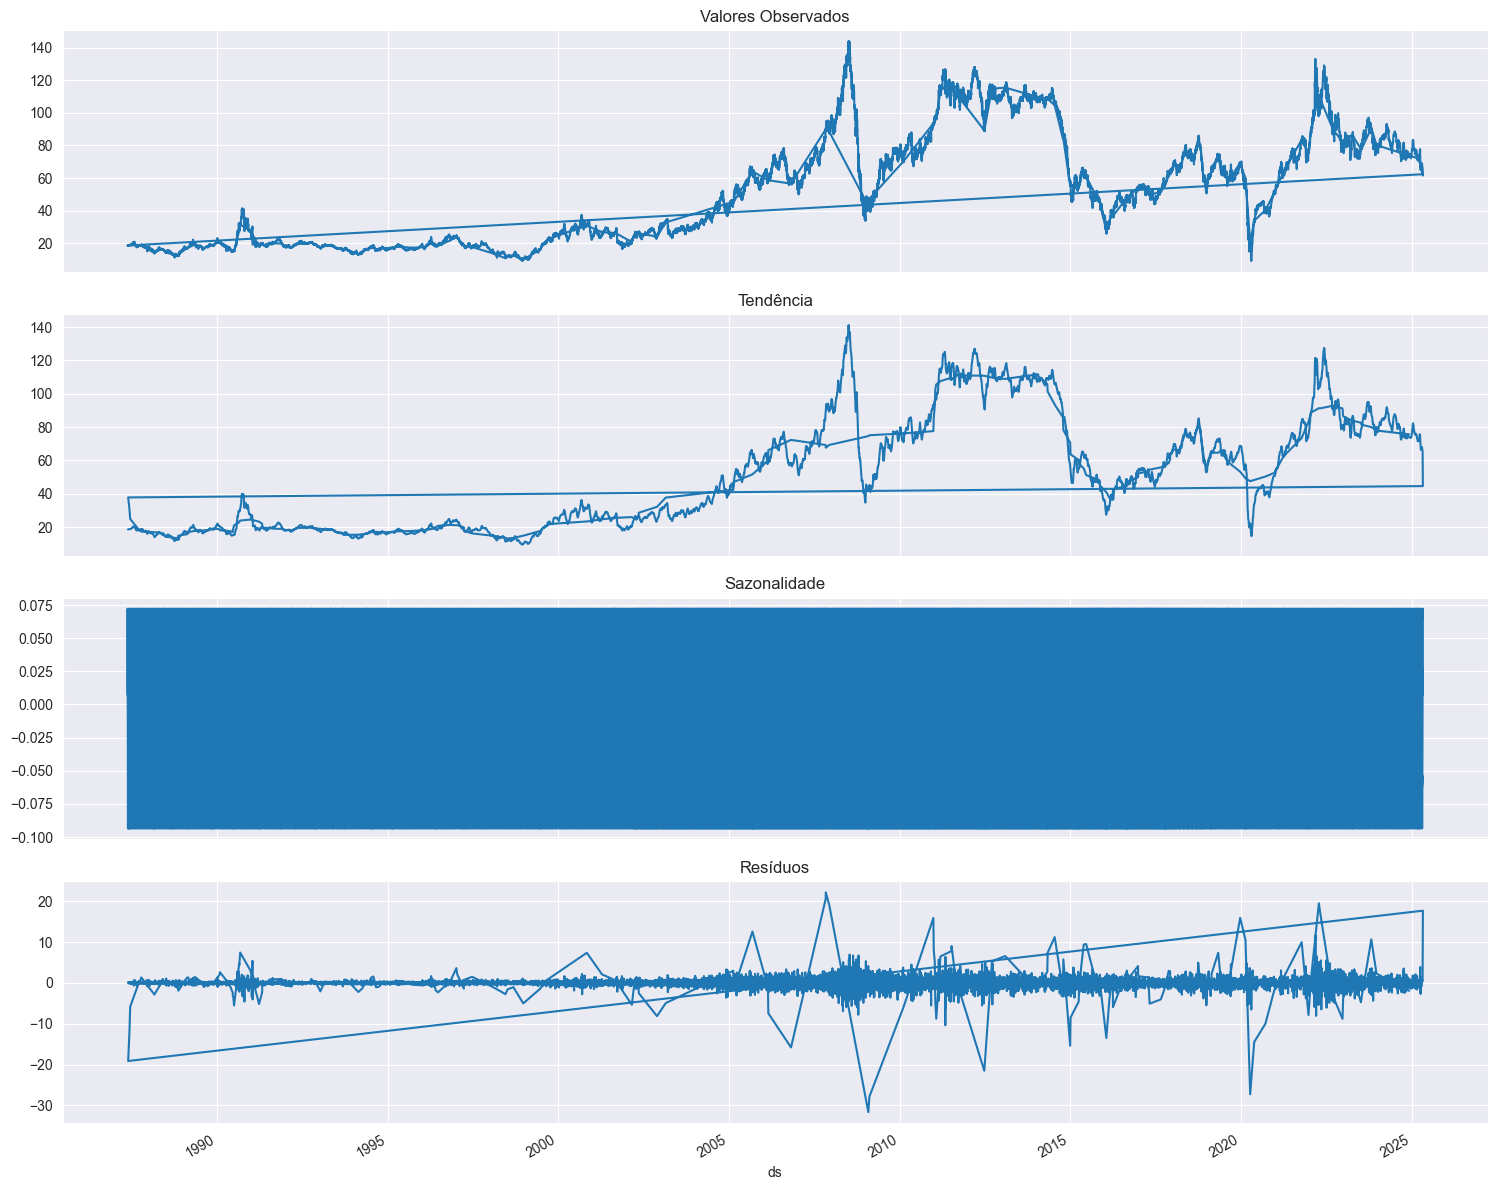

In [9]:
# Decompondo a série temporal
resultados = seasonal_decompose(dados_ipea['y'], model="additive", period=7)

# Visualizando os componentes
fig, axes = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

components = ['observed', 'trend', 'seasonal', 'resid']
titles = ['Valores Observados', 'Tendência', 'Sazonalidade', 'Resíduos']

for ax, component, title in zip(axes, components, titles):
    getattr(resultados, component).plot(ax=ax, legend=False)
    ax.set_title(title, fontsize=12)
    ax.grid(True)

plt.tight_layout()
plt.show()

#### Analisando se a série é estacionária ou não | Teste de Dickey-Fuller Aumentado (ADF)

In [10]:

X = dados_ipea.y.values

result = adfuller(X)

print("Teste ADF")
print(f"Teste Estatístico: {result[0]}")
print(f"P-Value: {result[1]}")
print("Valores críticos:")

for key, value in result[4].items():
  print(f"\t{key}: {value}")
  
  # Interpretação
if result[1] < 0.05:
    print("A série diferenciada é estacionária.")
else:
    print("A série diferenciada não é estacionária.")

Teste ADF
Teste Estatístico: -2.096692451630403
P-Value: 0.2458466616354114
Valores críticos:
	1%: -3.4309249121953567
	5%: -2.8617940803782798
	10%: -2.5669052418828904
A série diferenciada não é estacionária.


**Conclusão do Teste ADF:** O valor-p é maior do que 0.05. Nesse caso, não rejeitamos a hipótese nula, e assumimos que a série não é estacionária.

#### Aplicando métodos de diferenciação na série não estacionária:

* **Diferenciação de Primeira Ordem**
Usada para remover tendências não estacionárias nos dados.

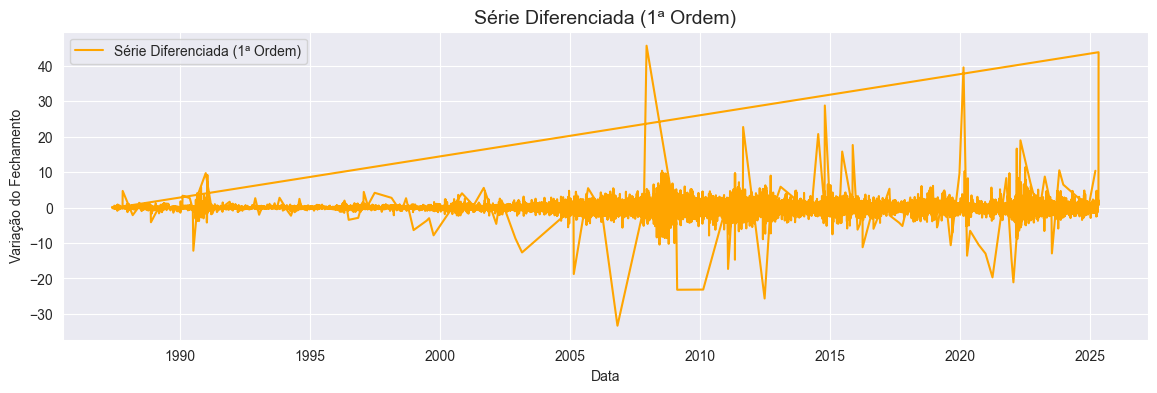

In [11]:
# Diferenciação de primeira ordem
dados_ipea['y_diff'] = dados_ipea['y'].diff().dropna()

# Gráfico da série diferenciada
plt.figure(figsize=(14, 4))
plt.plot(dados_ipea['y_diff'], label="Série Diferenciada (1ª Ordem)", color='orange')
plt.title("Série Diferenciada (1ª Ordem)", fontsize=14)
plt.xlabel("Data")
plt.ylabel("Variação do Fechamento")
plt.legend()
plt.grid(True)
plt.show()


**Aplicando o Teste ADF na Série Transformada**

In [12]:
# Teste ADF na série diferenciada
resultado_adf_diff = adfuller(dados_ipea["y_diff"].dropna())
print(f"Estatística ADF: {resultado_adf_diff[0]}")
print(f"Valor-p: {resultado_adf_diff[1]}")

# Interpretação
if resultado_adf_diff[1] < 0.05:
    print("A série diferenciada é estacionária.")
else:
    print("A série diferenciada não é estacionária.")

Estatística ADF: -19.444008384952465
Valor-p: 0.0
A série diferenciada é estacionária.


In [13]:
dados_ipea.head(5)

,y,ano,y_diff
ds,,,
2025-05-02,61.57,2025,NaN
2025-03-17,71.93,2025,10.36
2024-12-24,73.50,2024,1.57
2024-12-05,73.78,2024,0.28
2023-12-22,80.23,2023,6.45


**Conclusão do Teste ADF:** O valor-p é menor do que 0.05. Nesse caso, rejeitamos a hipótese nula, e assumimos que a série, aplicado a diferenciação de primeira ordem, é estacionária.

####  Identificação dos Parâmetros para o Modelo
Funções de Autocorrelação (ACF) e Autocorrelação Parcial (PACF)

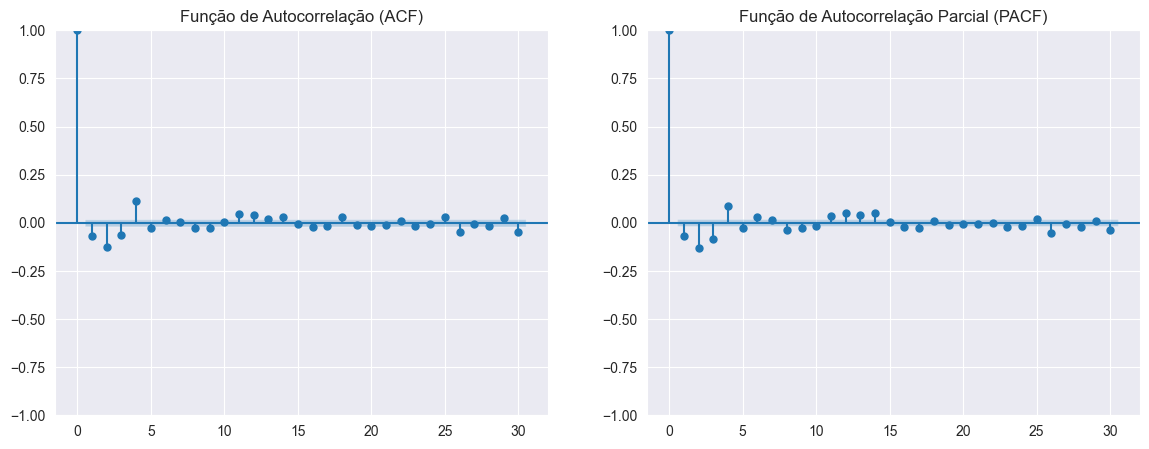

In [14]:
# Plot da ACF e PACF da série diferenciada
plt.figure(figsize=(14, 5))
plt.subplot(121)
plot_acf(dados_ipea["y_diff"].dropna(), ax=plt.gca(), lags=30)
plt.title("Função de Autocorrelação (ACF)")
plt.subplot(122)
plot_pacf(dados_ipea["y_diff"].dropna(), ax=plt.gca(), lags=30)
plt.title("Função de Autocorrelação Parcial (PACF)")
plt.show()

**Interpretação:**

- **Determinação de p (ordem AR):** O lag após o qual a PACF corta (drop-off) indica o valor de p.
  - p = 1: A PACF corta após o lag 5.

- **Determinação de q (ordem MA):** O lag após o qual a ACF corta indica o valor de q.
  - q = 1: A ACF corta após o lag 5.

In [15]:
# Definindo as variáveis
p = 5
q = 5
d = 1

####  7º Aplicação dos Modelos: Análise e comparação de resultados

**Separando os dados em Teste e Treino**

Para a base de testes foi considerado o período de Janeiro de 2010 até Novembro de 2024

Para a base de treino foi considerado os 30 dias de Dezembro

In [16]:
# Separando os datasets de treino e validação
train_data = dados_ipea.loc[(dados_ipea.index > '1987-05-20') & (dados_ipea.index <= '2025-02-28')]
validacao = dados_ipea.loc[(dados_ipea.index > '2025-03-01') & (dados_ipea.index <= '2025-05-02')]

In [17]:
# Verificando se existem valores ausentes no dataset Treino e Validação.
if train_data.isnull().sum().sum() > 0:
    print("Valores ausentes em `train_data`. Preenchendo com valores anteriores.")
    train_data = train_data.fillna(method='ffill')

if validacao.isnull().sum().sum() > 0:
    print("Valores ausentes em `validacao`. Removendo ou preenchendo.")
    validacao = validacao.fillna(method='ffill')

Valores ausentes em `validacao`. Removendo ou preenchendo.


In [18]:
# Ajustando o dataset Treino
train_data =  train_data.reset_index()
train_data.rename(columns={'index':'id'}, inplace=True)
train_data['unique_id'] = train_data['ds'].dt.year

# Ajustando o dataset Validação
validacao = validacao.reset_index()
validacao['unique_id'] = validacao['ds'].dt.year

Abaixo será criada uma função para Verificar a ponderação do erro:

In [19]:
# Criando a função wmape para analisar o resultado
def wmape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

**7.1 Arima**

Modelo estatístico usado para séries temporais, bom para dados não sazonais e estacionários.

In [20]:
# Modelo ARIMA com dados de treino
model_arima_train = ARIMA(train_data['y'], order=(p, d, q))
resultado_arima_train = model_arima_train.fit()
forecast_arima_train = resultado_arima_train.forecast(steps=43)

In [21]:
forecast_arima_train_clean = forecast_arima_train.dropna()

# Calcular o WMAPE
wmape_result_arima= wmape(
    validacao['y'].values,  # Valores reais da validação
    forecast_arima_train_clean.values  # Valores previstos pelo ARIMA
)
print(f'WMAPE ARIMA: {wmape_result_arima:.2%}')

WMAPE ARIMA: 73.62%


**7.2 Sarima**

Extensão do ARIMA que incorpora sazonalidade, adequado para séries temporais sazonais.

In [22]:
# Modelo SARIMA com dados de treino
s = 30
model_sarima_train = SARIMAX(train_data['y'], order=(p, d, q), seasonal_order=(1, 1, 0, s))
resultado_sarima_train = model_sarima_train.fit()
forecast_sarima_train = resultado_sarima_train.forecast(steps=43)

In [23]:
forecast_sarima_train_clean = forecast_sarima_train.dropna()
# Calcular o WMAPE
wmape_result_sarima = wmape(
    validacao['y'].values,  # Valores reais da validação
    forecast_sarima_train_clean.values  # Valores previstos pelo ARIMA
)
print(f'WMAPE SARIMA: {wmape_result_sarima:.2%}')

WMAPE SARIMA: 73.20%


**7.3 Naive - Baseline Simplificado**

Modelo probabilístico simples baseado no Teorema de Bayes.

In [24]:
# Previsão para: 30 dias
h = 30

model = StatsForecast(models=[Naive()], freq = 'D', n_jobs = -1) 
model.fit(train_data)

forecast_df = model.predict(h=h, level = [95]) # nivel de confiança 95%
forecast_df = forecast_df.reset_index().merge(validacao, on=['ds', 'unique_id'], how = 'left')
forecast_ = forecast_df.dropna(subset=['y'])

In [25]:
# Calcular o WMAPE
wmape_result_NB = wmape(forecast_['y'].values, forecast_['Naive'].values)
print(f'WMAPE NAIVE: {wmape_result_NB:.2%}')

WMAPE NAIVE: 3.11%


**7.4 - SeasonalNaive: Baseline  com Sazonalidade**

Método simples que prevê os valores futuros com base nos valores passados correspondentes ao mesmo período sazonal.

In [26]:
# Modelo Naive
model_sn = StatsForecast(models=[SeasonalNaive(season_length=5)], freq = 'D', n_jobs = -1)
model_sn.fit(train_data)

StatsForecast(models=[SeasonalNaive])

In [27]:
forecast_sn = model_sn.predict(h=h, level = [95]) # nivel de confiança 90%
forecast_sn = forecast_sn.reset_index().merge(validacao, on=['ds', 'unique_id'], how = 'left')
forecast_sn = forecast_sn.dropna(subset=['y'])

In [28]:
# Calcular o WMAPE
wmape_sn = wmape(forecast_sn['y'].values, forecast_sn['SeasonalNaive'].values)
print(f'WMAPE SEASONALNAIVE: {wmape_sn:.2%}')

WMAPE SEASONALNAIVE: 2.79%


**7.5 - Seasonal Window Average: Baseline de Média Móvel com Sazonalidade**


Baseia-se na média dos valores passados dentro de uma janela de tempo sazonal.

In [29]:
# Modelo Sasonal Naive
model_swa = StatsForecast(models=[SeasonalWindowAverage(season_length=5, window_size = 2)], freq='D', n_jobs=-1)
model_swa.fit(train_data)

StatsForecast(models=[SeasWA])

In [30]:
forecast_swa = model_swa.predict(h=h)
forecast_swa = forecast_swa.reset_index().merge(validacao, on=['ds', 'unique_id'], how = 'left')
forecast_swa = forecast_swa.dropna(subset=['y'])

In [31]:
# Calcular o WMAPE
wmape_swa = wmape(forecast_swa['y'].values, forecast_swa['SeasWA'].values)
print(f'WMAPE SeasonalWindowAverage: {wmape_swa:.2%}')

WMAPE SeasonalWindowAverage: 3.67%


#### Avaliando as métricas dos modelos:

In [32]:
# Função para avaliar as métricas de todos os modelos
def avaliar_metricas(y_true, y_pred, model_name="Modelo"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    wmape = np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))
    acuracia = 100 - mape 

    # Create a DataFrame to store the results
    results_df = pd.DataFrame({
        "Modelo": model_name,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape,
        "WMAPE": wmape,
        "Accuracy (%)": acuracia
    }, index=[0])
    
    return results_df

In [33]:
# Avaliando os modelos e armazenando os resultados em um DataFrame
results_df = pd.concat([
    avaliar_metricas(y_true=validacao['y'].values, y_pred=forecast_arima_train_clean.values, model_name="ARIMA"),
    avaliar_metricas(y_true=validacao['y'].values, y_pred=forecast_sarima_train_clean.values, model_name="SARIMA"),
    avaliar_metricas(y_true=forecast_['y'].values, y_pred=forecast_['Naive'].values, model_name="Naive"),
    avaliar_metricas(y_true=forecast_sn['y'].values, y_pred=forecast_sn['SeasonalNaive'].values, model_name="Seasonal Naive"),
    avaliar_metricas(y_true=forecast_swa['y'].values, y_pred=forecast_swa['SeasWA'].values, model_name="Seasonal Window Average")
])

# Verificando o resultado dos nossos modelos
results_df

,Modelo,MAE,RMSE,MAPE,WMAPE,Accuracy (%)
0,ARIMA,51.604542,51.757010,73.536363,0.736224,26.463637
0,SARIMA,51.311322,51.466734,73.114859,0.732041,26.885141
0,Naive,2.252000,2.560781,3.134768,0.031059,96.865232
0,Seasonal Naive,2.025000,2.329633,2.812681,0.027928,97.187319
0,Seasonal Window Average,2.662000,2.962582,3.700344,0.036713,96.299656


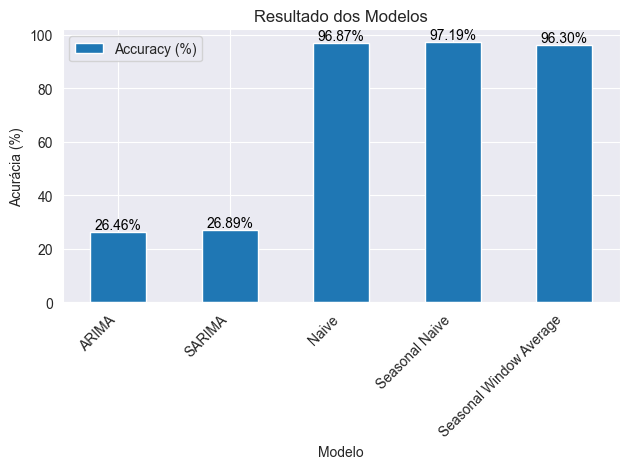

In [34]:
# Visualizando graficamente todos os modelos
ax = results_df.plot(kind='bar', y=['Accuracy (%)'], x='Modelo')

# Ajustando a rotação dos rótulos no eixo X para 45 graus
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Definindo título e rótulos
ax.set_title('Resultado dos Modelos')
ax.set_ylabel('Acurácia (%)')

# Exibindo o valor em cada barra
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=10, color='black', 
                xytext=(0, 5), textcoords='offset points')

# Ajustando o layout para evitar sobreposição
ax.get_figure().set_tight_layout(True)

# Exibindo o gráfico
plt.show()
